In [2]:
##create tools

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [ ]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)# main wrapper around the arxiv api 
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)#provides invoke to simply query arxiv easily
arxiv.invoke("Attention is All you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [7]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.invoke("Attention is All you need")

'Page: Attention Is All You Need\nSummary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi'

In [8]:
wiki.name

'wikipedia'

In [11]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults, TavilyAnswer
tavily = TavilySearchResults()
tavily.invoke("Give me latest news")

'Major global events include significant political developments, natural disasters, and technological advancements. Recent updates focus on international relations, climate change, and health crises. Stay informed for the latest news.'

In [14]:
#combine all the tools in a list
tools = [arxiv,wiki,tavily]


In [15]:
#init llm model
from langchain_groq import ChatGroq

llm = ChatGroq(
    model = "qwen-qwq-32b"
)
llm.invoke("Hi")

AIMessage(content='\n<think>\nOkay, the user said "Hi". I should respond politely. Let me see... Maybe "Hello! How can I assist you today?" That sounds friendly and opens the conversation. Wait, is there anything else I should add? Maybe keep it simple and not overcomplicate. Yeah, that should work.\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 11, 'total_tokens': 85, 'completion_time': 0.183902035, 'prompt_time': 0.004963032, 'queue_time': 6.5112399, 'total_time': 0.188865067}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'stop', 'logprobs': None}, id='run--a8d358ef-c45e-4f84-9635-c5a50d2b576e-0', usage_metadata={'input_tokens': 11, 'output_tokens': 74, 'total_tokens': 85})

In [17]:
llm_with_tools = llm.bind_tools(tools = tools)


In [18]:
llm_with_tools.invoke("What is the latest news on AI?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dwth', 'function': {'arguments': '{"query":"latest news on AI"}', 'name': 'tavily_answer'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 178, 'prompt_tokens': 413, 'total_tokens': 591, 'completion_time': 0.444497544, 'prompt_time': 0.070826833, 'queue_time': 0.725771274, 'total_time': 0.515324377}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6e2acdfd-a97c-4b4a-bfbd-98fd9c625748-0', tool_calls=[{'name': 'tavily_answer', 'args': {'query': 'latest news on AI'}, 'id': 'call_dwth', 'type': 'tool_call'}], usage_metadata={'input_tokens': 413, 'output_tokens': 178, 'total_tokens': 591})

Langraph part

In [21]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage#human message or ai message
from typing import Annotated #annotation labelling
from langgraph.graph.message import add_messages #reducers as in append without overwriting

In [22]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [23]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition

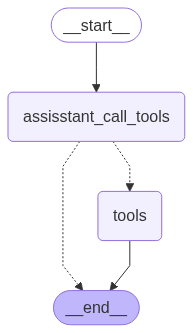

In [25]:
#node def
def assisstant_call_tools(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}
#build graph
builder = StateGraph(State)
builder.add_node("assisstant_call_tools", assisstant_call_tools)
builder.add_node("tools",ToolNode(tools))
#edges 
builder.add_edge(START,"assisstant_call_tools")
builder.add_conditional_edges(
    "assisstant_call_tools",tools_condition
)
builder.add_edge("tools",END)

#compile
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
#TEST
messages = graph.invoke({"messages":"Hi, what is the recent news on Agentic AI and give me the recent paper on the same"})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, what is the recent news on Agentic AI and give me the recent paper on the same
================================== Ai Message ==================================
Tool Calls:
  tavily_answer (call_rkcg)
 Call ID: call_rkcg
  Args:
    query: recent news on Agentic AI
  arxiv (call_7qrh)
 Call ID: call_7qrh
  Args:
    query: Agentic AI
================================= Tool Message =================================
Name: tavily_answer

Agentic AI is rapidly evolving, with Microsoft introducing new tools at Build 2025. IBM and AWS are collaborating on new agentic AI capabilities. The agentic AI market is projected to reach $41 billion.
================================= Tool Message =================================
Name: arxiv

Published: 2025-02-25
Title: Responsible AI Agents
Authors: Deven R. Desai, Mark O. Riedl
Summary: Thanks to advances in large language models, a new type of software agent,
the ar

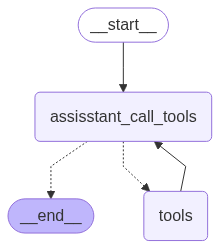

In [32]:
# node def
def assisstant_call_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(State)
builder.add_node("assisstant_call_tools", assisstant_call_tools)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START, "assisstant_call_tools")
builder.add_conditional_edges(
    "assisstant_call_tools", tools_condition
)
builder.add_edge("tools", "assisstant_call_tools")  # loop back to assistant
builder.add_edge("assisstant_call_tools", END)      # allow exit

# compile
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
messages = graph.invoke({"messages":"Hi, what is the recent news on Agentic AI and give me the recent paper on the same"})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, what is the recent news on Agentic AI and give me the recent paper on the same
================================== Ai Message ==================================
Tool Calls:
  tavily_answer (call_bhgm)
 Call ID: call_bhgm
  Args:
    query: recent news on Agentic AI
  arxiv (call_6c4d)
 Call ID: call_6c4d
  Args:
    query: Agentic AI
================================= Tool Message =================================
Name: tavily_answer

Agentic AI is advancing with new tools from Microsoft, AWS, and IBM, focusing on autonomous agents that perform tasks. The technology is transforming workforce capabilities. Recent announcements are emphasizing responsible AI deployment.
================================= Tool Message =================================
Name: arxiv

Published: 2025-02-25
Title: Responsible AI Agents
Authors: Deven R. Desai, Mark O. Riedl
Summary: Thanks to advances in large language models, a